In [ ]:
# Cell 1: Imports
import os
import urllib.request
import gzip
import shutil
import glob
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyfaidx
import traceback
import math
import random
import warnings

# ViennaRNA Python bindings
# If missing:  pip install viennarna
import RNA  # https://www.tbi.univie.ac.at/RNA/ViennaRNA/doc/html/api_python.html

# Parallel / stats
from multiprocess import Pool, cpu_count
from tqdm.notebook import tqdm
from scipy.stats import f_oneway, spearmanr
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
# Cell 2: Configuration & Parameters

# --- DEBUG MODE ---
DEBUG_MODE = False

# --- I/O and Processing Parameters ---
GENOME_DIR = "human_genome_hg38"
MASTER_WINDOW_FILE = "genome_windows_all.csv"
RESULTS_FILE = "genome_wide_accessibility_results.csv"
ENVIRONMENT_FILE = "environment.yml"
N_SAMPLES = 100000
NUM_CORES = cpu_count()

# --- Core Model Parameters ---
PROBE_LENGTH   = 5
WINDOW_SIZE    = 1000
FRAGMENT_LENGTH = 100

# --- Experimental Conditions ---
BASE_TEMPERATURE_C = 39.0
FORMAMIDE_PERCENT  = 70.0
# heuristic: +7°C per 10% formamide  -> +49°C
EFFECTIVE_TEMPERATURE_C = BASE_TEMPERATURE_C + (FORMAMIDE_PERCENT / 10.0 * 7.0)

# Mg2+ approximated as monovalent equivalent (your assumption)
EQUIVALENT_SALT_mM = 150.0  # treat as ~150 mM NaCl

# --- Accessibility Heuristics (Consensus Model) ---
P_OPEN_THRESHOLD     = 0.50   # site considered "Open" if P^u(i, L) >= threshold
CONSENSUS_THRESHOLD  = 0.50   # fragment "Accessible" if >=50% sites open

# --- RNAplfold-style local settings for small fragments ---
PFL_ULENGTH      = PROBE_LENGTH            # maximum unpaired segment tracked
PFL_WINDOW_SIZE  = FRAGMENT_LENGTH         # slide over the whole fragment
PFL_MAX_BP_SPAN  = FRAGMENT_LENGTH         # allow pairs across the fragment

# --- Set ViennaRNA *global defaults* so pfl_fold_up uses them ---
# (These are documented global defaults accessible via RNA.cvar.*)
# Temperature (°C)
RNA.cvar.temperature = float(EFFECTIVE_TEMPERATURE_C)
# Salt (M) if available in your installed version (>=2.6+)
if hasattr(RNA.cvar, "salt"):
    RNA.cvar.salt = float(EQUIVALENT_SALT_mM) / 1000.0

# Style & RNG
random.seed(42); np.random.seed(42); sns.set_theme(style="whitegrid", palette="viridis")

print("--- Pipeline Configuration ---")
print(f"Sample Size: {N_SAMPLES:,} fragments")
print(f"Parallel Cores to be Used: {NUM_CORES}")
print(f"ViennaRNA Temperature set to: {RNA.cvar.temperature:.1f}°C")
if hasattr(RNA.cvar, "salt"):
    print(f"ViennaRNA Salt set to: {RNA.cvar.salt:.3f} M")
else:
    print("ViennaRNA Salt setting not available in this build; proceeding without explicit salt.")
print(f"Debug Mode: {DEBUG_MODE}")
print("----------------------------")


--- Pipeline Configuration ---
Sample Size: 100,000 fragments
Parallel Cores to be Used: 8
ViennaRNA Temperature set to: 88.0°C
ViennaRNA Salt set to: 0.150 M
Debug Mode: False
----------------------------


In [5]:
# Cell 3: Core Function Definitions

# --- I/O and Data Preparation ---
def download_file(url, target_path_gz):
    """Downloads a file if it doesn't already exist."""
    target_path = target_path_gz.replace('.gz', '')
    if not os.path.exists(target_path_gz) and not os.path.exists(target_path):
        print(f"Downloading {os.path.basename(url)}...")
        try:
            urllib.request.urlretrieve(url, target_path_gz)
            print(" -> Done.")
        except Exception as e:
            print(f" -> FAILED to download. Error: {e}.")
    else:
        print(f"Found existing file for {os.path.basename(url)}. Skipping download.")

def calculate_gc_content(sequence: str) -> float:
    if not sequence: return 0.0
    s = sequence.upper()
    return 100.0 * (s.count('G') + s.count('C')) / len(s)

def create_genomic_windows(fasta_file, window_size):
    """Parses a single FASTA file into windows and computes GC content."""
    try:
        fasta = pyfaidx.Fasta(fasta_file); chrom = list(fasta.keys())[0]
        windows = []
        for s in range(0, len(fasta[chrom]) - window_size + 1, window_size):
            seq = fasta[chrom][s:s+window_size].seq.upper()
            if 'N' in seq: 
                continue
            windows.append({
                "chrom": chrom,
                "start": s,
                "gc_content": calculate_gc_content(seq)
            })
        return pd.DataFrame(windows)
    except Exception as e:
        print(f"Error processing {fasta_file}: {e}")
        return pd.DataFrame()

def perform_stratified_sampling(df, n_samples):
    """Stratified proportional sampling by GC bin."""
    gc_bins = [0, 35, 45, 55, 65, 101]
    gc_bin_labels = ["0-35%", "35-45%", "45-55%", "55-65%", "65-100%"]
    df = df.copy()
    df['gc_bin'] = pd.cut(df['gc_content'], bins=gc_bins, labels=gc_bin_labels, right=False)
    df.dropna(subset=['gc_bin'], inplace=True)
    with pd.option_context('mode.chained_assignment', None):
        sampled_df = df.groupby('gc_bin', group_keys=False, observed=False).apply(
            lambda x: x.sample(int(np.ceil(n_samples * len(x) / len(df))), random_state=42)
        )
    return sampled_df

# --- Core Biophysics: unpaired segment probabilities via pfl_fold_up ---
def get_up_matrix(sequence: str, ulength: int) -> np.ndarray:
    """
    Return a (N+1) x (ulength+1) matrix M with 1-based indexing where:
      M[i, L] = P^u( segment of length L starting at position i )  for i in [1..N], L in [1..ulength]
    We defensively handle SWIG index quirks by trying 1-based then 0-based fill.
    """
    # Use RNA energy set (empirical proxy for DNA): convert T->U
    rna_seq = sequence.replace('T', 'U')
    N = len(rna_seq)
    M = np.zeros((N + 1, ulength + 1), dtype=float)
    try:
        # pfl_fold_up uses *global* model defaults (temperature/salt) we set in Cell 2
        mat = RNA.pfl_fold_up(rna_seq, int(ulength), int(max(PFL_WINDOW_SIZE, N)), int(max(PFL_MAX_BP_SPAN, N)))
        if mat is None:
            return M  # all zeros (fail-safe)
        # Prefer documented 1-based layout (X[100][5] is P^u(100,5)) 
        # https://viennarna.readthedocs.io/en/latest/api_python.html  (pfl_fold_up)
        for i in range(1, N + 1):
            row = mat[i]
            # row may be (ulength+1) or larger; ignore 0th entry if present
            maxL = min(ulength, len(row) - 1)
            for L in range(1, maxL + 1):
                M[i, L] = row[L]
        return M
    except Exception:
        # Fallback: attempt 0-based interpretation
        try:
            for i in range(N):
                row = mat[i]
                maxL = min(ulength, len(row))
                for L in range(maxL):
                    M[i + 1, L + 1] = row[L]
        except Exception:
            pass
        return M

def analyze_fragment_accessibility_from_up(sequence: str, up: np.ndarray, probe_len: int) -> dict:
    """
    Given the up-matrix (1-based) and sequence, compute:
      - p_open_array: P^u(i, probe_len) for all valid starts
      - frac_open_sites and is_accessible under the consensus heuristic
    """
    N = len(sequence)
    valid = N - probe_len + 1
    if valid < 1:
        return {"frac_open_sites": 0.0, "is_accessible": False, "p_open_array": np.array([]), "pu1": np.array([])}

    # Per-base unpaired (L=1) for plotting (length N)
    pu1 = np.array([up[i, 1] for i in range(1, N + 1)])
    # P(open) for each 5-mer start i
    p_open_array = np.array([up[i, probe_len] for i in range(1, valid + 1)])
    open_sites_count = int(np.sum(p_open_array >= P_OPEN_THRESHOLD))
    frac_open_sites = open_sites_count / valid
    is_accessible = frac_open_sites >= CONSENSUS_THRESHOLD

    return {
        "frac_open_sites": frac_open_sites,
        "is_accessible": is_accessible,
        "p_open_array": p_open_array,
        "pu1": pu1
    }

# --- Main worker for parallel run ---
def process_fragment_accessibility(args):
    """Analyze one fragment with pfl_fold_up. `args` contains fragment details and meta."""
    fragment_details = args
    sequence = fragment_details['sequence']
    gc_bin   = fragment_details['gc_bin']
    gc_content = fragment_details['gc_content']
    try:
        up = get_up_matrix(sequence, PROBE_LENGTH)
        metrics = analyze_fragment_accessibility_from_up(sequence, up, PROBE_LENGTH)
        return {
            "sequence": sequence,
            "gc_content": gc_content,
            "gc_bin": gc_bin,
            "frac_open_sites": metrics['frac_open_sites'],
            "is_accessible": metrics['is_accessible']
        }
    except Exception as e:
        print(f"--- Worker error --- {type(e).__name__}: {e}\n{traceback.format_exc()}")
        return None

# --- Plot: two-panel profile using P^u(i,1) and P^u(i,PROBE_LENGTH) ---
def plot_fragment_profile_with_up(sequence: str, up: np.ndarray, title: str, upright_bases: bool = True):
    N = len(sequence)
    pu1 = np.array([up[i, 1] for i in range(1, N + 1)])
    valid = N - PROBE_LENGTH + 1
    p_open_array = np.array([up[i, PROBE_LENGTH] for i in range(1, max(0, valid) + 1)])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    # Top: P(unpaired) per base
    ax1.plot(np.arange(N), pu1, marker='o', markersize=4, linestyle='-')
    ax1.set_ylabel('P(unpaired)')
    ax1.set_ylim(-0.05, 1.05)
    ax1.set_title(title, fontsize=14)
    ax1.grid(True, alpha=0.6)

    # Bottom: P(open) for 5-mer starts
    probe_pos = np.arange(valid) + (PROBE_LENGTH - 1) / 2
    ax2.bar(probe_pos, p_open_array, width=1.0, alpha=0.6, label='P(open)')
    ax2.axhline(y=P_OPEN_THRESHOLD, color='gray', linestyle='--',
                label=f'P(open) Threshold = {P_OPEN_THRESHOLD}')
    ax2.set_ylabel('Probe P(open)')
    ax2.set_ylim(-0.05, 1.05)
    ax2.legend()

    # X axis: actual bases (upright by default)
    ax2.set_xlabel('Sequence Base')
    ticks = np.arange(N)
    labels = list(sequence)
    ax2.set_xticks(ticks)
    ax2.set_xticklabels(labels, fontfamily='monospace', rotation=0 if upright_bases else 90, ha='center')
    ax2.tick_params(axis='x', labelrotation=0 if upright_bases else 90)
    ax2.set_xlim(-0.5, N - 0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("All core functions defined successfully (pfl_fold_up-based).")


All core functions defined successfully (pfl_fold_up-based).


In [7]:
# Cell 4: Download & Pre-compute
UCSC_BASE_URL = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/chromosomes/"
CHROMOSOMES = [f"chr{i}" for i in range(1, 23)] + ["chrX", "chrY"]
os.makedirs(GENOME_DIR, exist_ok=True)

print(f"--- Checking Genome Files in '{GENOME_DIR}' ---")
for chrom in CHROMOSOMES:
    download_file(f"{UCSC_BASE_URL}{chrom}.fa.gz", os.path.join(GENOME_DIR, f"{chrom}.fa.gz"))

print("\nDecompressing files (if necessary)...")
for f_gz in glob.glob(os.path.join(GENOME_DIR, '*.fa.gz')):
    f_fa = f_gz.replace('.gz', '')
    if not os.path.exists(f_fa):
        with gzip.open(f_gz, 'rb') as f_in, open(f_fa, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

if not os.path.exists(MASTER_WINDOW_FILE):
    print(f"\n--- Generating Master Window File '{MASTER_WINDOW_FILE}' ---")
    chromosome_files = sorted(glob.glob(os.path.join(GENOME_DIR, 'chr*.fa')))
    all_windows_dfs = [create_genomic_windows(f, WINDOW_SIZE) for f in tqdm(chromosome_files, desc="Windowing Chromosomes")]
    master_windows_df = pd.concat([df for df in all_windows_dfs if not df.empty], ignore_index=True)
    master_windows_df.to_csv(MASTER_WINDOW_FILE, index=False)
    print(f"Master catalog saved with {len(master_windows_df):,} windows.")
else:
    print(f"\n--- Loading Master Window File '{MASTER_WINDOW_FILE}' ---")
    master_windows_df = pd.read_csv(MASTER_WINDOW_FILE)
    print(f"Loaded {len(master_windows_df):,} windows.")


--- Checking Genome Files in 'human_genome_hg38' ---
Found existing file for chr1.fa.gz. Skipping download.
Found existing file for chr2.fa.gz. Skipping download.
Found existing file for chr3.fa.gz. Skipping download.
Found existing file for chr4.fa.gz. Skipping download.
Found existing file for chr5.fa.gz. Skipping download.
Found existing file for chr6.fa.gz. Skipping download.
Found existing file for chr7.fa.gz. Skipping download.
Found existing file for chr8.fa.gz. Skipping download.
Found existing file for chr9.fa.gz. Skipping download.
Found existing file for chr10.fa.gz. Skipping download.
Found existing file for chr11.fa.gz. Skipping download.
Found existing file for chr12.fa.gz. Skipping download.
Found existing file for chr13.fa.gz. Skipping download.
Found existing file for chr14.fa.gz. Skipping download.
Found existing file for chr15.fa.gz. Skipping download.
Found existing file for chr16.fa.gz. Skipping download.
Found existing file for chr17.fa.gz. Skipping download.
Foun

In [8]:
# Cell 5: Run the Parallelized Simulation
print(f"\n--- Starting Main Simulation (Debug Mode: {DEBUG_MODE}) ---")
if DEBUG_MODE:
    print("WARNING: Running in slow debug mode for 5 fragments.")
else:
    print(f"Using {NUM_CORES} cores for {N_SAMPLES} samples.")

sampled_windows_df = perform_stratified_sampling(master_windows_df, N_SAMPLES)

print("Indexing chromosome files for efficient access...")
fa_files = sorted(glob.glob(os.path.join(GENOME_DIR, 'chr*.fa')))
genome_fastas = {os.path.basename(f).split('.')[0]: pyfaidx.Fasta(f) for f in fa_files}
fragments_to_process = []

print("Extracting fragments for analysis...")
for _, row in tqdm(sampled_windows_df.iterrows(), total=len(sampled_windows_df), desc="Extracting Fragments"):
    chrom = row['chrom']
    if chrom in genome_fastas:
        frag_start = row['start'] + random.randint(0, WINDOW_SIZE - FRAGMENT_LENGTH)
        seq = genome_fastas[chrom][chrom][frag_start : frag_start + FRAGMENT_LENGTH].seq.upper()
        if 'N' not in seq:
            fragments_to_process.append({
                "sequence": seq,
                "gc_bin": row['gc_bin'],
                "gc_content": calculate_gc_content(seq)
            })

results_list = []
if DEBUG_MODE:
    for task in tqdm(fragments_to_process[:5], desc="Debug Run"):
        res = process_fragment_accessibility(task)
        if res is not None:
            results_list.append(res)
    print("Debug run complete.")
else:
    start_time = time.time()
    with Pool(NUM_CORES) as p:
        results_iterator = p.imap(process_fragment_accessibility, fragments_to_process)
        results_list = [res for res in tqdm(results_iterator, total=len(fragments_to_process), desc="Analyzing Fragments") if res is not None]
    end_time = time.time()
    print(f"\nFull simulation complete. Total time: {end_time - start_time:.2f} seconds.")

if not results_list:
    print("\nERROR: No results were generated.")
    results_df = pd.DataFrame()
else:
    results_df = pd.DataFrame(results_list).dropna()
    results_df.to_csv(RESULTS_FILE, index=False)
    print(f"Genome-wide simulation results saved to {RESULTS_FILE}")



--- Starting Main Simulation (Debug Mode: False) ---
Using 8 cores for 100000 samples.


/var/folders/v9/tqgrsgq57dbbjxxb5cd8dv5w0000gn/T/ipykernel_52746/2029597537.py:49: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('gc_bin', group_keys=False, observed=False).apply(
python(67525) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Indexing chromosome files for efficient access...
Extracting fragments for analysis...


Extracting Fragments:   0%|          | 0/100003 [00:00<?, ?it/s]

python(67563) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67564) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67565) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Analyzing Fragments:   0%|          | 0/100003 [00:00<?, ?it/s]


Full simulation complete. Total time: 1808.86 seconds.
Genome-wide simulation results saved to genome_wide_accessibility_results.csv


--- Simulation Conclusion ---
Based on a stratified sample of 100,003 fragments, the model estimates that:
Overall, 79.32% of genomic fragments are accessible.
The 95% Confidence Interval for this estimate is: 79.07% to 79.57%


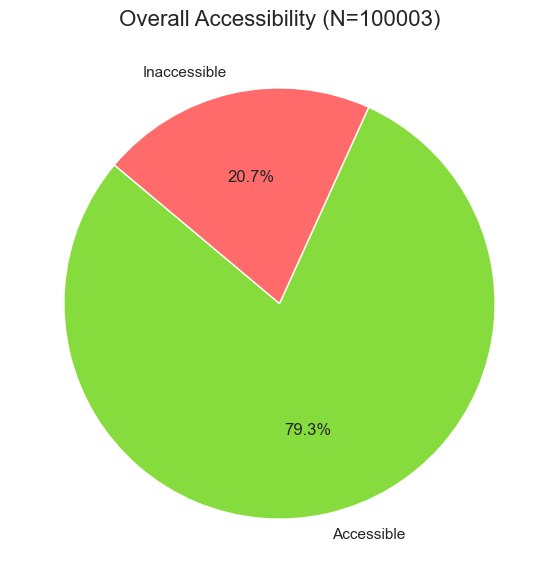

In [9]:
# Cell 6: Overall Summary, Confidence Interval, and Pie Chart
if 'results_df' in locals() and not results_df.empty:
    total_fragments = len(results_df)
    accessible_count = results_df['is_accessible'].sum()
    p_hat = accessible_count / total_fragments
    z = 1.96
    margin_of_error = z * np.sqrt((p_hat * (1 - p_hat)) / total_fragments)
    
    print("--- Simulation Conclusion ---")
    print(f"Based on a stratified sample of {total_fragments:,} fragments, the model estimates that:")
    print(f"Overall, {p_hat:.2%} of genomic fragments are accessible.")
    print(f"The 95% Confidence Interval for this estimate is: {p_hat - margin_of_error:.2%} to {p_hat + margin_of_error:.2%}")

    plt.figure(figsize=(7, 7))
    plt.pie([accessible_count, total_fragments - accessible_count],
            labels=['Accessible', 'Inaccessible'], autopct='%1.1f%%',
            colors=['#86dc3d', '#ff6b6b'], startangle=140)
    plt.title(f'Overall Accessibility (N={total_fragments})', fontsize=16)
    plt.show()
else:
    print("Results DataFrame is empty. Skipping analysis.")


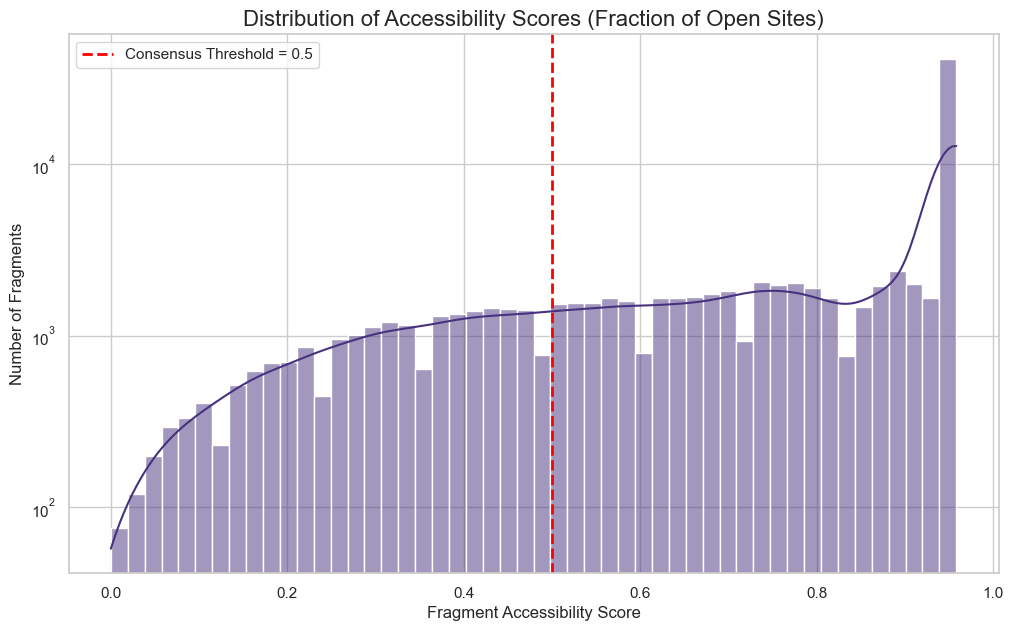

In [10]:
# Cell 7: Histogram of Accessibility Scores (log y-axis)
if 'results_df' in locals() and not results_df.empty:
    plt.figure(figsize=(12, 7))
    ax = sns.histplot(data=results_df, x='frac_open_sites', bins=50, kde=True)
    plt.axvline(x=CONSENSUS_THRESHOLD, color='r', linestyle='--', linewidth=2,
                label=f'Consensus Threshold = {CONSENSUS_THRESHOLD}')
    plt.yscale('log')  # log scale to de-emphasize very tall bars
    plt.title('Distribution of Accessibility Scores (Fraction of Open Sites)', fontsize=16)
    plt.xlabel('Fragment Accessibility Score')
    plt.ylabel('Number of Fragments')
    plt.legend()
    plt.show()


/var/folders/v9/tqgrsgq57dbbjxxb5cd8dv5w0000gn/T/ipykernel_52746/3495730149.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax1, data=results_df, x='gc_bin', y='frac_open_sites',


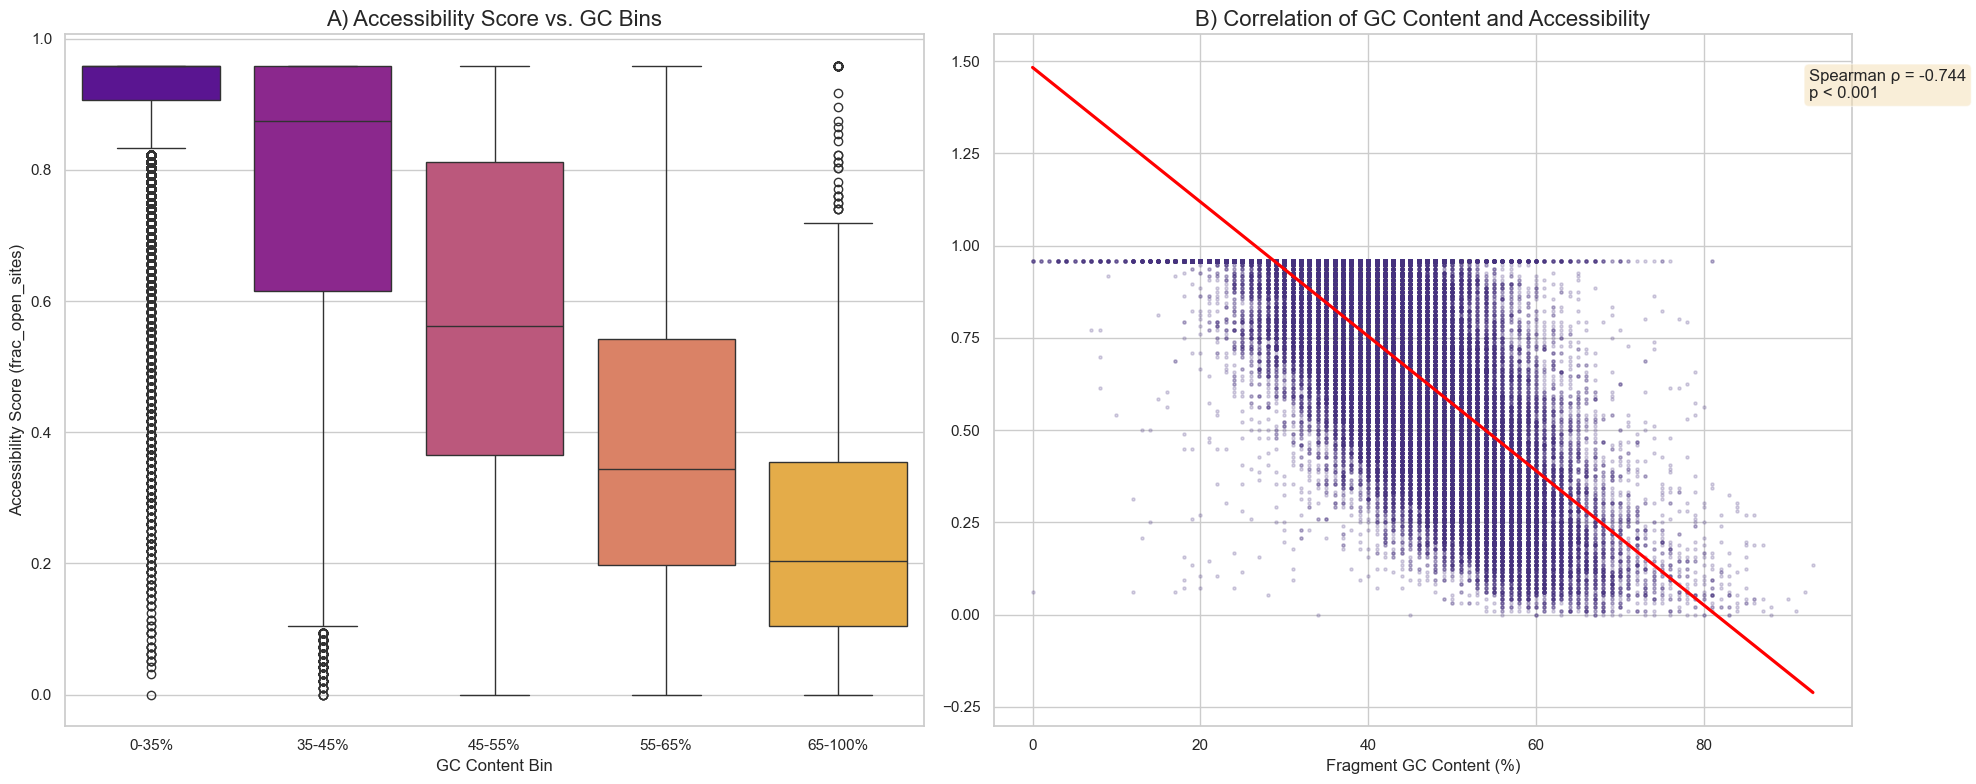

--- ANOVA: Accessibility vs. GC Bins (P-value: 0.00e+00) ---
Conclusion: Significant differences among GC bins.


In [11]:
# Cell 8: GC Content vs. Accessibility Analysis
if 'results_df' in locals() and not results_df.empty:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    gc_bin_order = ["0-35%", "35-45%", "45-55%", "55-65%", "65-100%"]
    sns.boxplot(ax=ax1, data=results_df, x='gc_bin', y='frac_open_sites',
                order=gc_bin_order, palette='plasma')
    ax1.set_title('A) Accessibility Score vs. GC Bins', fontsize=16)
    ax1.set_xlabel('GC Content Bin'); ax1.set_ylabel('Accessibility Score (frac_open_sites)')

    sns.regplot(ax=ax2, data=results_df, x='gc_content', y='frac_open_sites',
                scatter_kws={'alpha':0.2, 's':5}, line_kws={'color':'red'})
    ax2.set_title('B) Correlation of GC Content and Accessibility', fontsize=16)
    ax2.set_xlabel('Fragment GC Content (%)'); ax2.set_ylabel('')
    corr, pval = spearmanr(results_df['gc_content'], results_df['frac_open_sites'])
    ax2.text(0.95, 0.95, f'Spearman ρ = {corr:.3f}\np < 0.001',
             transform=ax2.transAxes, fontsize=12, va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.tight_layout(); plt.show()

    # ANOVA across bins
    gc_bins_data = [results_df['frac_open_sites'][results_df['gc_bin'] == gc_bin]
                    for gc_bin in gc_bin_order if not results_df[results_df['gc_bin'] == gc_bin].empty]
    f_stat, p_value = f_oneway(*gc_bins_data)
    print(f"--- ANOVA: Accessibility vs. GC Bins (P-value: {p_value:.2e}) ---")
    print("Conclusion: Significant differences among GC bins."
          if p_value < 0.05 else "Conclusion: No significant difference among GC bins.")



--- Generating Profiles for Extreme Fragments ---


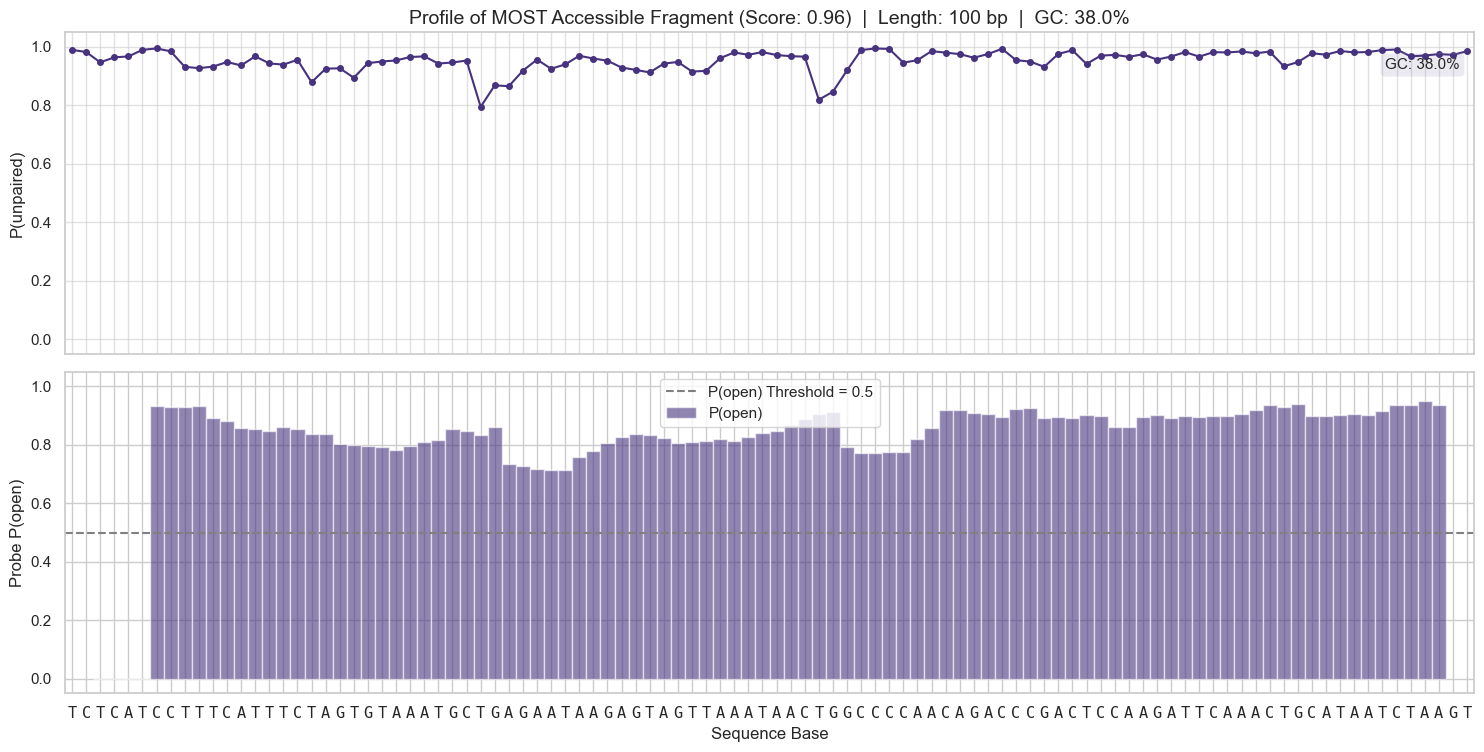

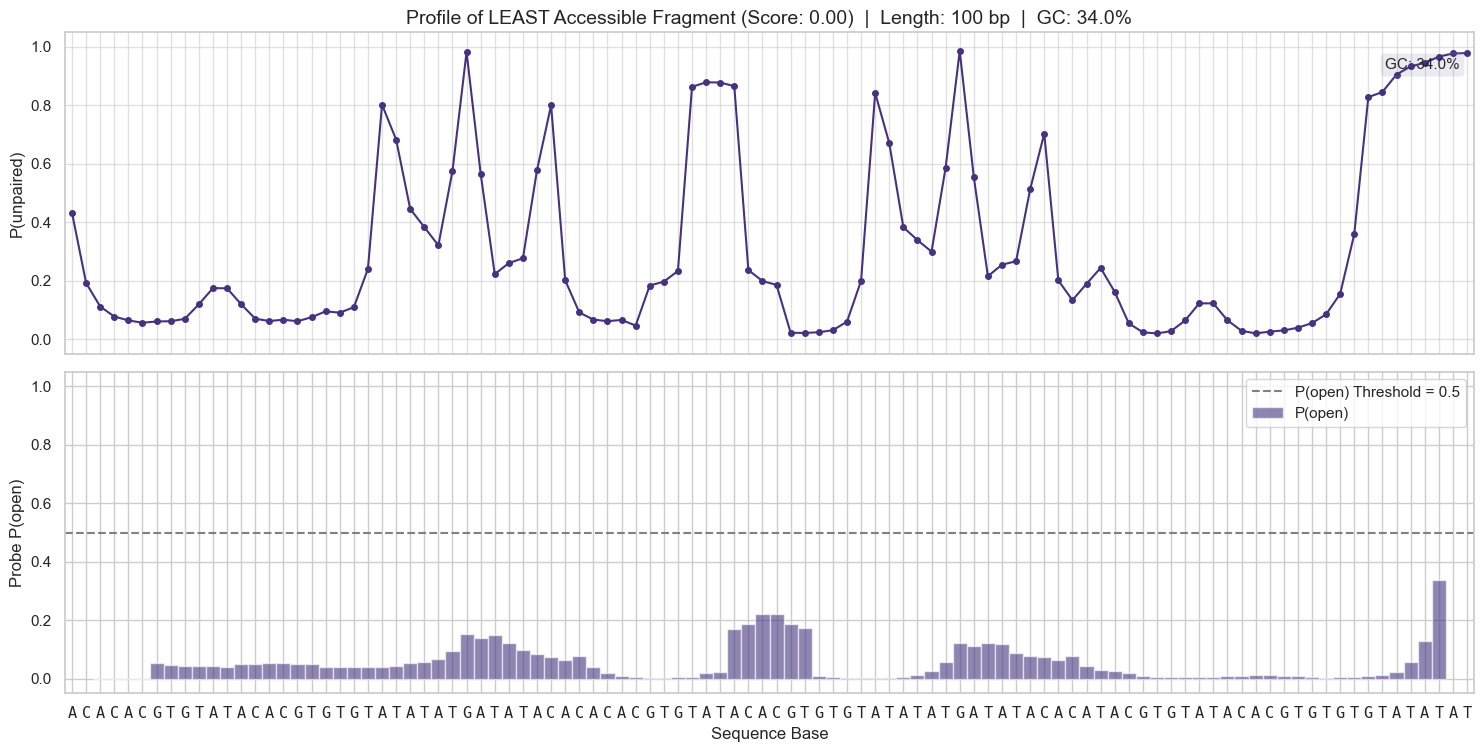

In [12]:
# Cell 9: Plot the Most and Least Accessible Fragments (self-contained, pfl_fold_up)
if 'results_df' in locals() and not results_df.empty:
    import numpy as np
    import matplotlib.pyplot as plt

    def _gc_content(seq: str) -> float:
        if not seq: return 0.0
        s = seq.upper()
        return 100.0 * (s.count('G') + s.count('C')) / len(s)

    def _plot_profile_with_up(sequence: str, up: np.ndarray, title_prefix: str):
        N = len(sequence)
        pu1 = np.array([up[i, 1] for i in range(1, N + 1)])
        valid = N - PROBE_LENGTH + 1
        p_open_array = np.array([up[i, PROBE_LENGTH] for i in range(1, max(0, valid) + 1)])
        gc = _gc_content(sequence)

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

        ax1.plot(np.arange(N), pu1, marker='o', markersize=4, linestyle='-')
        ax1.set_ylabel('P(unpaired)')
        ax1.set_ylim(-0.05, 1.05)
        ax1.set_title(f"{title_prefix}  |  Length: {N} bp  |  GC: {gc:.1f}%", fontsize=14)
        ax1.grid(True, alpha=0.6)
        ax1.text(0.99, 0.92, f"GC: {gc:.1f}%", transform=ax1.transAxes,
                 ha='right', va='top', fontsize=11, bbox=dict(boxstyle='round', alpha=0.1))

        probe_pos = np.arange(valid) + (PROBE_LENGTH - 1) / 2
        ax2.bar(probe_pos, p_open_array, width=1.0, alpha=0.6, label='P(open)')
        ax2.axhline(y=P_OPEN_THRESHOLD, color='gray', linestyle='--',
                    label=f'P(open) Threshold = {P_OPEN_THRESHOLD}')
        ax2.set_ylabel('Probe P(open)')
        ax2.set_ylim(-0.05, 1.05)
        ax2.legend()

        # Bases upright on x-axis
        ax2.set_xlabel('Sequence Base')
        ticks = np.arange(N)
        labels = list(sequence)
        ax2.set_xticks(ticks)
        ax2.set_xticklabels(labels, fontfamily='monospace', rotation=0, ha='center')
        ax2.tick_params(axis='x', labelrotation=0)
        ax2.set_xlim(-0.5, N - 0.5)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    print("\n--- Generating Profiles for Extreme Fragments ---")
    most_accessible = results_df.loc[results_df['frac_open_sites'].idxmax()]
    seq_most = most_accessible['sequence']
    up_most = get_up_matrix(seq_most, PROBE_LENGTH)
    title = f"Profile of MOST Accessible Fragment (Score: {most_accessible['frac_open_sites']:.2f})"
    _plot_profile_with_up(seq_most, up_most, title)

    least_accessible = results_df.loc[results_df['frac_open_sites'].idxmin()]
    seq_least = least_accessible['sequence']
    up_least = get_up_matrix(seq_least, PROBE_LENGTH)
    title = f"Profile of LEAST Accessible Fragment (Score: {least_accessible['frac_open_sites']:.2f})"
    _plot_profile_with_up(seq_least, up_least, title)


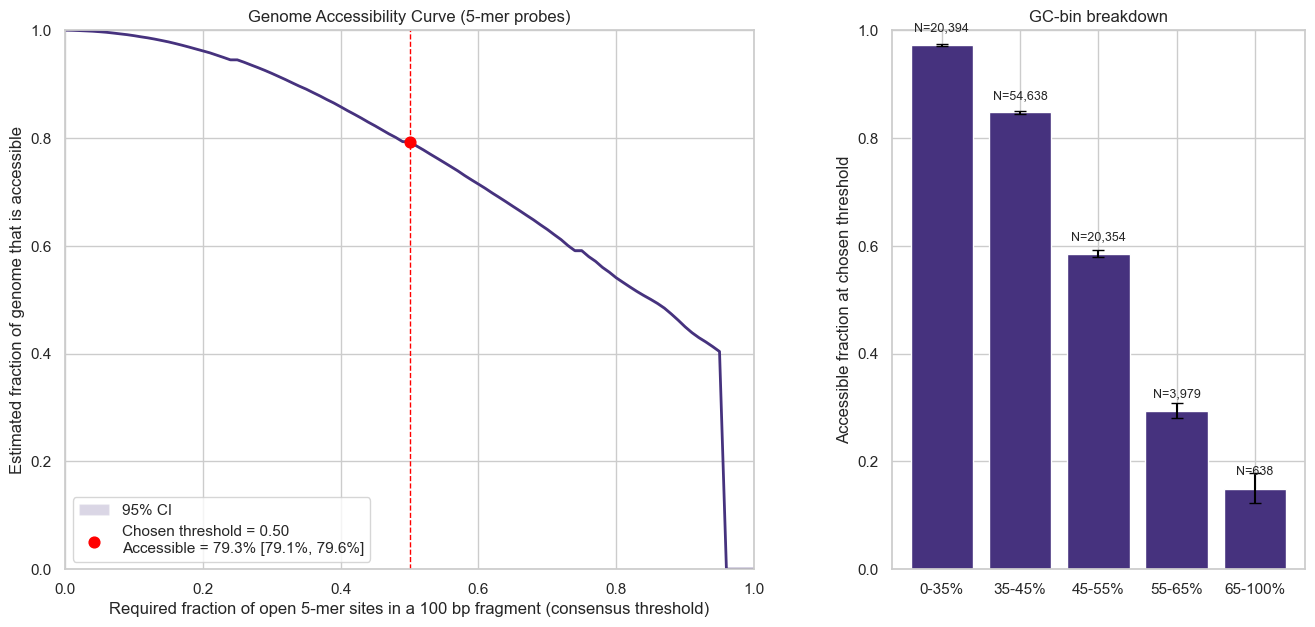

Headline: At consensus threshold = 0.50, estimated accessible genome fraction = 79.32% (95% CI 79.07% – 79.57%) over N=100,003 fragments.


In [15]:
# Cell X: Ultimate Genome Accessibility Plot (curve + GC-bin breakdown)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def _wilson_ci(k, n, z=1.96):
    """Wilson score interval for a binomial proportion."""
    if n == 0: 
        return (0.0, 0.0, 0.0)
    p = k / n
    denom = 1 + z**2 / n
    center = (p + z**2/(2*n)) / denom
    half = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2)) / denom
    return (p, max(0.0, center - half), min(1.0, center + half))

if 'results_df' in locals() and not results_df.empty:
    # 1) Genome Accessibility Curve (sweep consensus threshold t)
    t_grid = np.linspace(0, 1, 101)
    n = len(results_df)
    p_vals, lo, hi = [], [], []

    fs = results_df['frac_open_sites'].values
    for t in t_grid:
        k = int((fs >= t).sum())
        p, l, h = _wilson_ci(k, n)
        p_vals.append(p); lo.append(l); hi.append(h)

    # Value at your chosen threshold
    t_star = float(CONSENSUS_THRESHOLD)
    k_star = int((fs >= t_star).sum())
    p_star, l_star, h_star = _wilson_ci(k_star, n)

    # 2) GC-bin breakdown at chosen threshold
    gc_order = ["0-35%", "35-45%", "45-55%", "55-65%", "65-100%"]
    bin_stats = []
    for b in gc_order:
        sub = results_df[results_df['gc_bin'] == b]
        if sub.empty:
            continue
        k = int((sub['frac_open_sites'] >= t_star).sum())
        m = len(sub)
        p, l, h = _wilson_ci(k, m)
        bin_stats.append((b, p, l, h, m))

    # ---- Plotting ----
    sns.set_theme(style="whitegrid", palette="viridis")
    fig = plt.figure(figsize=(16, 7))
    gs = fig.add_gridspec(1, 2, width_ratios=[2.0, 1.2], wspace=0.25)

    # Panel A: Genome Accessibility Curve
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t_grid, p_vals, linewidth=2)
    ax1.fill_between(t_grid, lo, hi, alpha=0.2, label='95% CI')
    ax1.axvline(t_star, color='red', linestyle='--', linewidth=1)
    ax1.scatter([t_star], [p_star], s=60, color='red', zorder=3,
                label=f'Chosen threshold = {t_star:.2f}\nAccessible = {p_star:.1%} [{l_star:.1%}, {h_star:.1%}]')
    ax1.set_xlim(0, 1); ax1.set_ylim(0, 1)
    ax1.set_xlabel('Required fraction of open 5-mer sites in a 100 bp fragment (consensus threshold)')
    ax1.set_ylabel('Estimated fraction of genome that is accessible')
    ax1.set_title('Genome Accessibility Curve (5-mer probes)')
    ax1.legend(loc='lower left')

    # Panel B: GC-bin breakdown at chosen threshold
    ax2 = fig.add_subplot(gs[0, 1])
    if bin_stats:
        labels = [b for b,_,_,_,_ in bin_stats]
        vals   = [p for _,p,_,_,_ in bin_stats]
        lows   = [p - l for (_,p,l,_,_) in bin_stats]
        highs  = [h - p for (_,p,_,h,_) in bin_stats]
        errs   = [lows, highs]
        bars = ax2.bar(labels, vals)
        ax2.errorbar(labels, vals, yerr=errs, fmt='none', ecolor='black', capsize=4)
        ax2.set_ylim(0, 1)
        ax2.set_ylabel('Accessible fraction at chosen threshold')
        ax2.set_title('GC-bin breakdown')
        for rect, (_,p,_,_,m) in zip(bars, bin_stats):
            ax2.text(rect.get_x()+rect.get_width()/2, p+0.02, f"N={m:,}", ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(0.5, 0.5, "No GC-bin data available", ha='center', va='center')
        ax2.axis('off')

    plt.show()

    # A concise printout for the headline number:
    print(f"Headline: At consensus threshold = {t_star:.2f}, estimated accessible genome fraction = "
          f"{p_star:.2%} (95% CI {l_star:.2%} – {h_star:.2%}) over N={n:,} fragments.")
else:
    print("results_df is empty; run the simulation first.")


In [13]:
# Cell 10: Save Environment for Reproducibility
print("--- Saving Conda environment to environment.yml ---")
!conda env export > {ENVIRONMENT_FILE}
print(f"Environment saved successfully to '{ENVIRONMENT_FILE}'.")


--- Saving Conda environment to environment.yml ---


python(68907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Environment saved successfully to 'environment.yml'.


--- Analyzing Custom Sequence ---

--- Analysis Results ---
Sequence Length: 59 bp
GC Content: 72.88%
--------------------------
Fraction of Open 5bp Sites: 0.055
Consensus Threshold:           >=0.5
Final Classification:          INACCESSIBLE


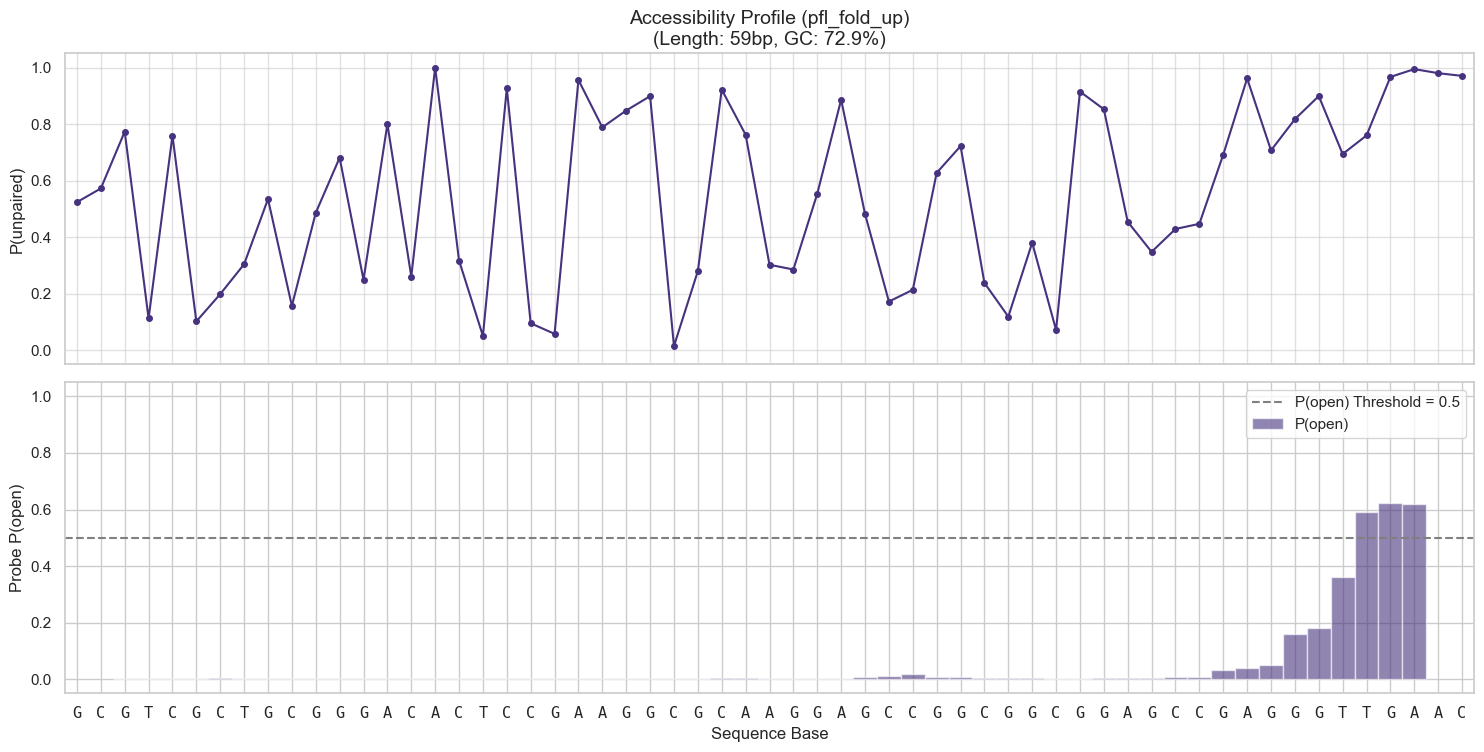

In [25]:
# Cell 11: Standalone Custom Sequence Analyzer (pfl_fold_up-based)

def run_custom_analysis(sequence_to_test: str, force_base_labels: bool = False):
    """
    Analyze a single DNA sequence for accessibility using ViennaRNA pfl_fold_up
    under your experimental conditions (temperature/salt set globally in Cell 2).
    """
    # --- Step 1: Imports (scoped) ---
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    import RNA

    # --- Step 2: Configuration (self-contained) ---
    PROBE_LENGTH = 5
    P_OPEN_THRESHOLD = 0.50
    CONSENSUS_THRESHOLD = 0.5

    # --- Step 3: Helpers ---
    def calculate_gc_content(sequence: str) -> float:
        if not sequence: return 0.0
        s = sequence.upper()
        return 100.0 * (s.count('G') + s.count('C')) / len(s)

    def get_up_matrix_local(sequence: str, ulength: int) -> np.ndarray:
        rna_sequence = sequence.replace('T', 'U')
        N = len(rna_sequence)
        M = np.zeros((N + 1, ulength + 1), dtype=float)
        mat = RNA.pfl_fold_up(rna_sequence, int(ulength), int(max(N, 100)), int(max(N, 100)))
        if mat is None:
            return M
        try:
            for i in range(1, N + 1):
                row = mat[i]
                maxL = min(ulength, len(row) - 1)
                for L in range(1, maxL + 1):
                    M[i, L] = row[L]
        except Exception:
            # 0-based fallback
            for i in range(N):
                row = mat[i]
                maxL = min(ulength, len(row))
                for L in range(maxL):
                    M[i + 1, L + 1] = row[L]
        return M

    def analyze_from_up(sequence: str, up: np.ndarray) -> dict:
        N = len(sequence)
        valid = N - PROBE_LENGTH + 1
        pu1 = np.array([up[i, 1] for i in range(1, N + 1)])
        p_open_array = np.array([up[i, PROBE_LENGTH] for i in range(1, max(0, valid) + 1)])
        open_sites = int(np.sum(p_open_array >= P_OPEN_THRESHOLD))
        frac_open_sites = open_sites / valid if valid > 0 else 0.0
        is_accessible = frac_open_sites >= CONSENSUS_THRESHOLD
        return {"frac_open_sites": frac_open_sites, "is_accessible": is_accessible,
                "pu1": pu1, "p_open_array": p_open_array}

    def plot_fragment_profile(sequence: str, up: np.ndarray, title: str, force_labels: bool):
        N = len(sequence)
        pu1 = np.array([up[i, 1] for i in range(1, N + 1)])
        valid = N - PROBE_LENGTH + 1
        p_open_array = np.array([up[i, PROBE_LENGTH] for i in range(1, max(0, valid) + 1)])

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
        ax1.plot(np.arange(N), pu1, marker='o', markersize=4, linestyle='-')
        ax1.set_ylabel('P(unpaired)'); ax1.set_ylim(-0.05, 1.05); ax1.set_title(title, fontsize=14); ax1.grid(True, alpha=0.6)
        probe_pos = np.arange(valid) + (PROBE_LENGTH - 1) / 2
        ax2.bar(probe_pos, p_open_array, width=1.0, alpha=0.6, label='P(open)')
        ax2.axhline(y=P_OPEN_THRESHOLD, color='gray', linestyle='--', label=f'P(open) Threshold = {P_OPEN_THRESHOLD}')
        ax2.set_ylabel('Probe P(open)'); ax2.set_ylim(-0.05, 1.05); ax2.legend()

        # X-axis labels (bases)
        ticks = np.arange(N)
        labels = list(sequence)
        ax2.set_xlabel('Sequence Base', fontsize=12)
        if force_labels or N <= 60:
            ax2.set_xticks(ticks)
            ax2.set_xticklabels(labels, fontfamily='monospace', rotation=0, ha='center')
        else:
            ax2.set_xticks(ticks[::max(1, N // 60)])
            thin_labels = [labels[i] for i in ticks[::max(1, N // 60)]]
            ax2.set_xticklabels(thin_labels, fontfamily='monospace', rotation=0, ha='center')
        ax2.set_xlim(-0.5, N - 0.5)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    # --- Step 4: Main ---
    print("--- Analyzing Custom Sequence ---")
    sequence = "\n".join([line for line in sequence_to_test.split('\n') if not line.startswith('>')])
    sequence = re.sub(r'[^ATGC]', '', sequence, flags=re.IGNORECASE).upper()
    if len(sequence) < PROBE_LENGTH:
        print("Error: Sequence is too short."); return
    gc = calculate_gc_content(sequence)
    up = get_up_matrix_local(sequence, PROBE_LENGTH)
    metrics = analyze_from_up(sequence, up)

    print("\n--- Analysis Results ---")
    print(f"Sequence Length: {len(sequence)} bp")
    print(f"GC Content: {gc:.2f}%")
    print("-" * 26)
    print(f"Fraction of Open {PROBE_LENGTH}bp Sites: {metrics['frac_open_sites']:.3f}")
    print(f"Consensus Threshold:           >={CONSENSUS_THRESHOLD}")
    classification = 'ACCESSIBLE' if metrics['is_accessible'] else 'INACCESSIBLE'
    print(f"Final Classification:          {classification}")
    title = f"Accessibility Profile (pfl_fold_up)\n(Length: {len(sequence)}bp, GC: {gc:.1f}%)"

    plot_fragment_profile(sequence, up, title, force_labels=force_base_labels)


# --- INSTRUCTIONS ---
sequence_to_test = """
>long_example_sequence
GCGTCGCTGCGGGACACTCCGAAGGCGCAAGGAGCCGGCGGCGGAGCCGAGGGTTGAAC
"""

FORCE_BASE_LABELS_ON_LONG_SEQUENCES = True
run_custom_analysis(sequence_to_test, force_base_labels=FORCE_BASE_LABELS_ON_LONG_SEQUENCES)


          ANALYSIS AT EXPERIMENTAL TEMPERATURE            
--- Running Full Comparative Analysis at 88.0°C ---
Input Sequence (L=64, GC=70.3%):
GTCTAGCGTCGCTGCGGGACACTCCGAAGGCGCAAGGAGCCGGCGGCGGAGCCGAGGGTTGAAC

-- Analyzing with model: RNA Turner 2004 --
  Fraction of Open 5bp Sites: 0.167

-- Analyzing with model: RNA Turner 1999 --
  Fraction of Open 5bp Sites: 0.467

-- Analyzing with model: RNA Andronescu 2007 --
  Fraction of Open 5bp Sites: 0.783

-- Analyzing with model: RNA Langdon 2018 --
  Fraction of Open 5bp Sites: 0.350

-- Analyzing with model: DNA Mathews 2004 --
  Fraction of Open 5bp Sites: 0.000

-- Analyzing with model: DNA Mathews 1999 --
  Fraction of Open 5bp Sites: 0.050

-- Analyzing with model: RNA Special Hairpins --
  Fraction of Open 5bp Sites: 0.050


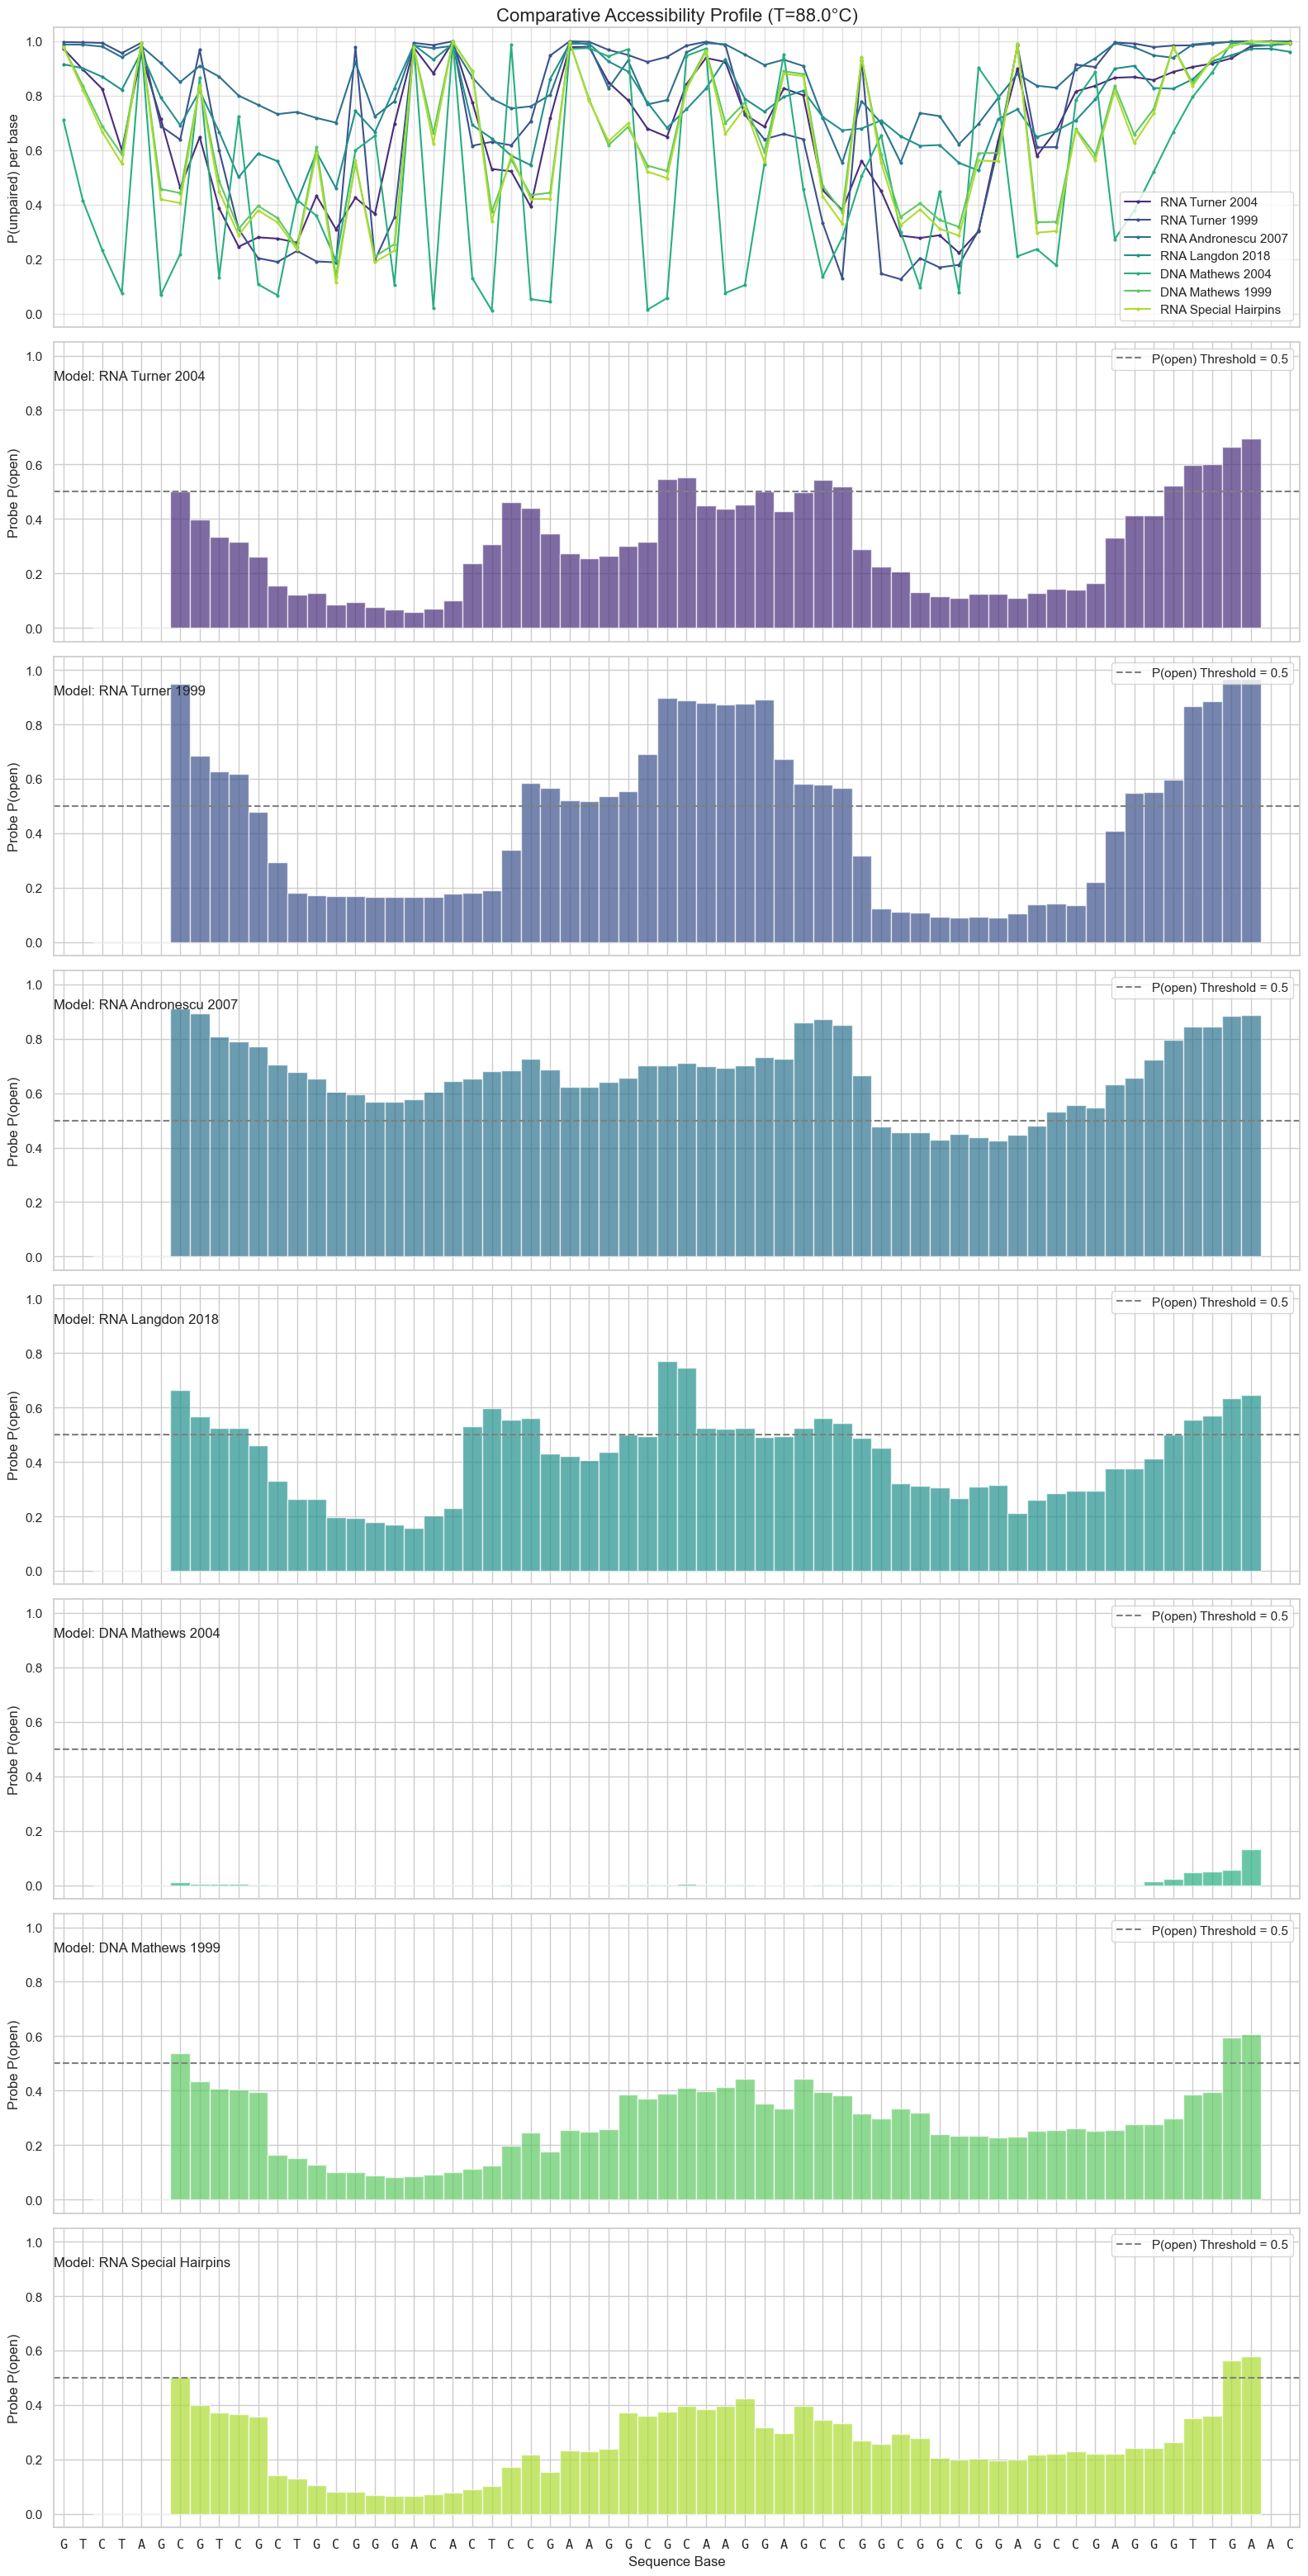



             ANALYSIS AT BIOLOGICAL TEMPERATURE             
--- Running Full Comparative Analysis at 37.0°C ---
Input Sequence (L=64, GC=70.3%):
GTCTAGCGTCGCTGCGGGACACTCCGAAGGCGCAAGGAGCCGGCGGCGGAGCCGAGGGTTGAAC

-- Analyzing with model: RNA Turner 2004 --
  Fraction of Open 5bp Sites: 0.100

-- Analyzing with model: RNA Turner 1999 --
  Fraction of Open 5bp Sites: 0.000

-- Analyzing with model: RNA Andronescu 2007 --
  Fraction of Open 5bp Sites: 0.033

-- Analyzing with model: RNA Langdon 2018 --
  Fraction of Open 5bp Sites: 0.000

-- Analyzing with model: DNA Mathews 2004 --
  Fraction of Open 5bp Sites: 0.017

-- Analyzing with model: DNA Mathews 1999 --
  Fraction of Open 5bp Sites: 0.050

-- Analyzing with model: RNA Special Hairpins --
  Fraction of Open 5bp Sites: 0.050


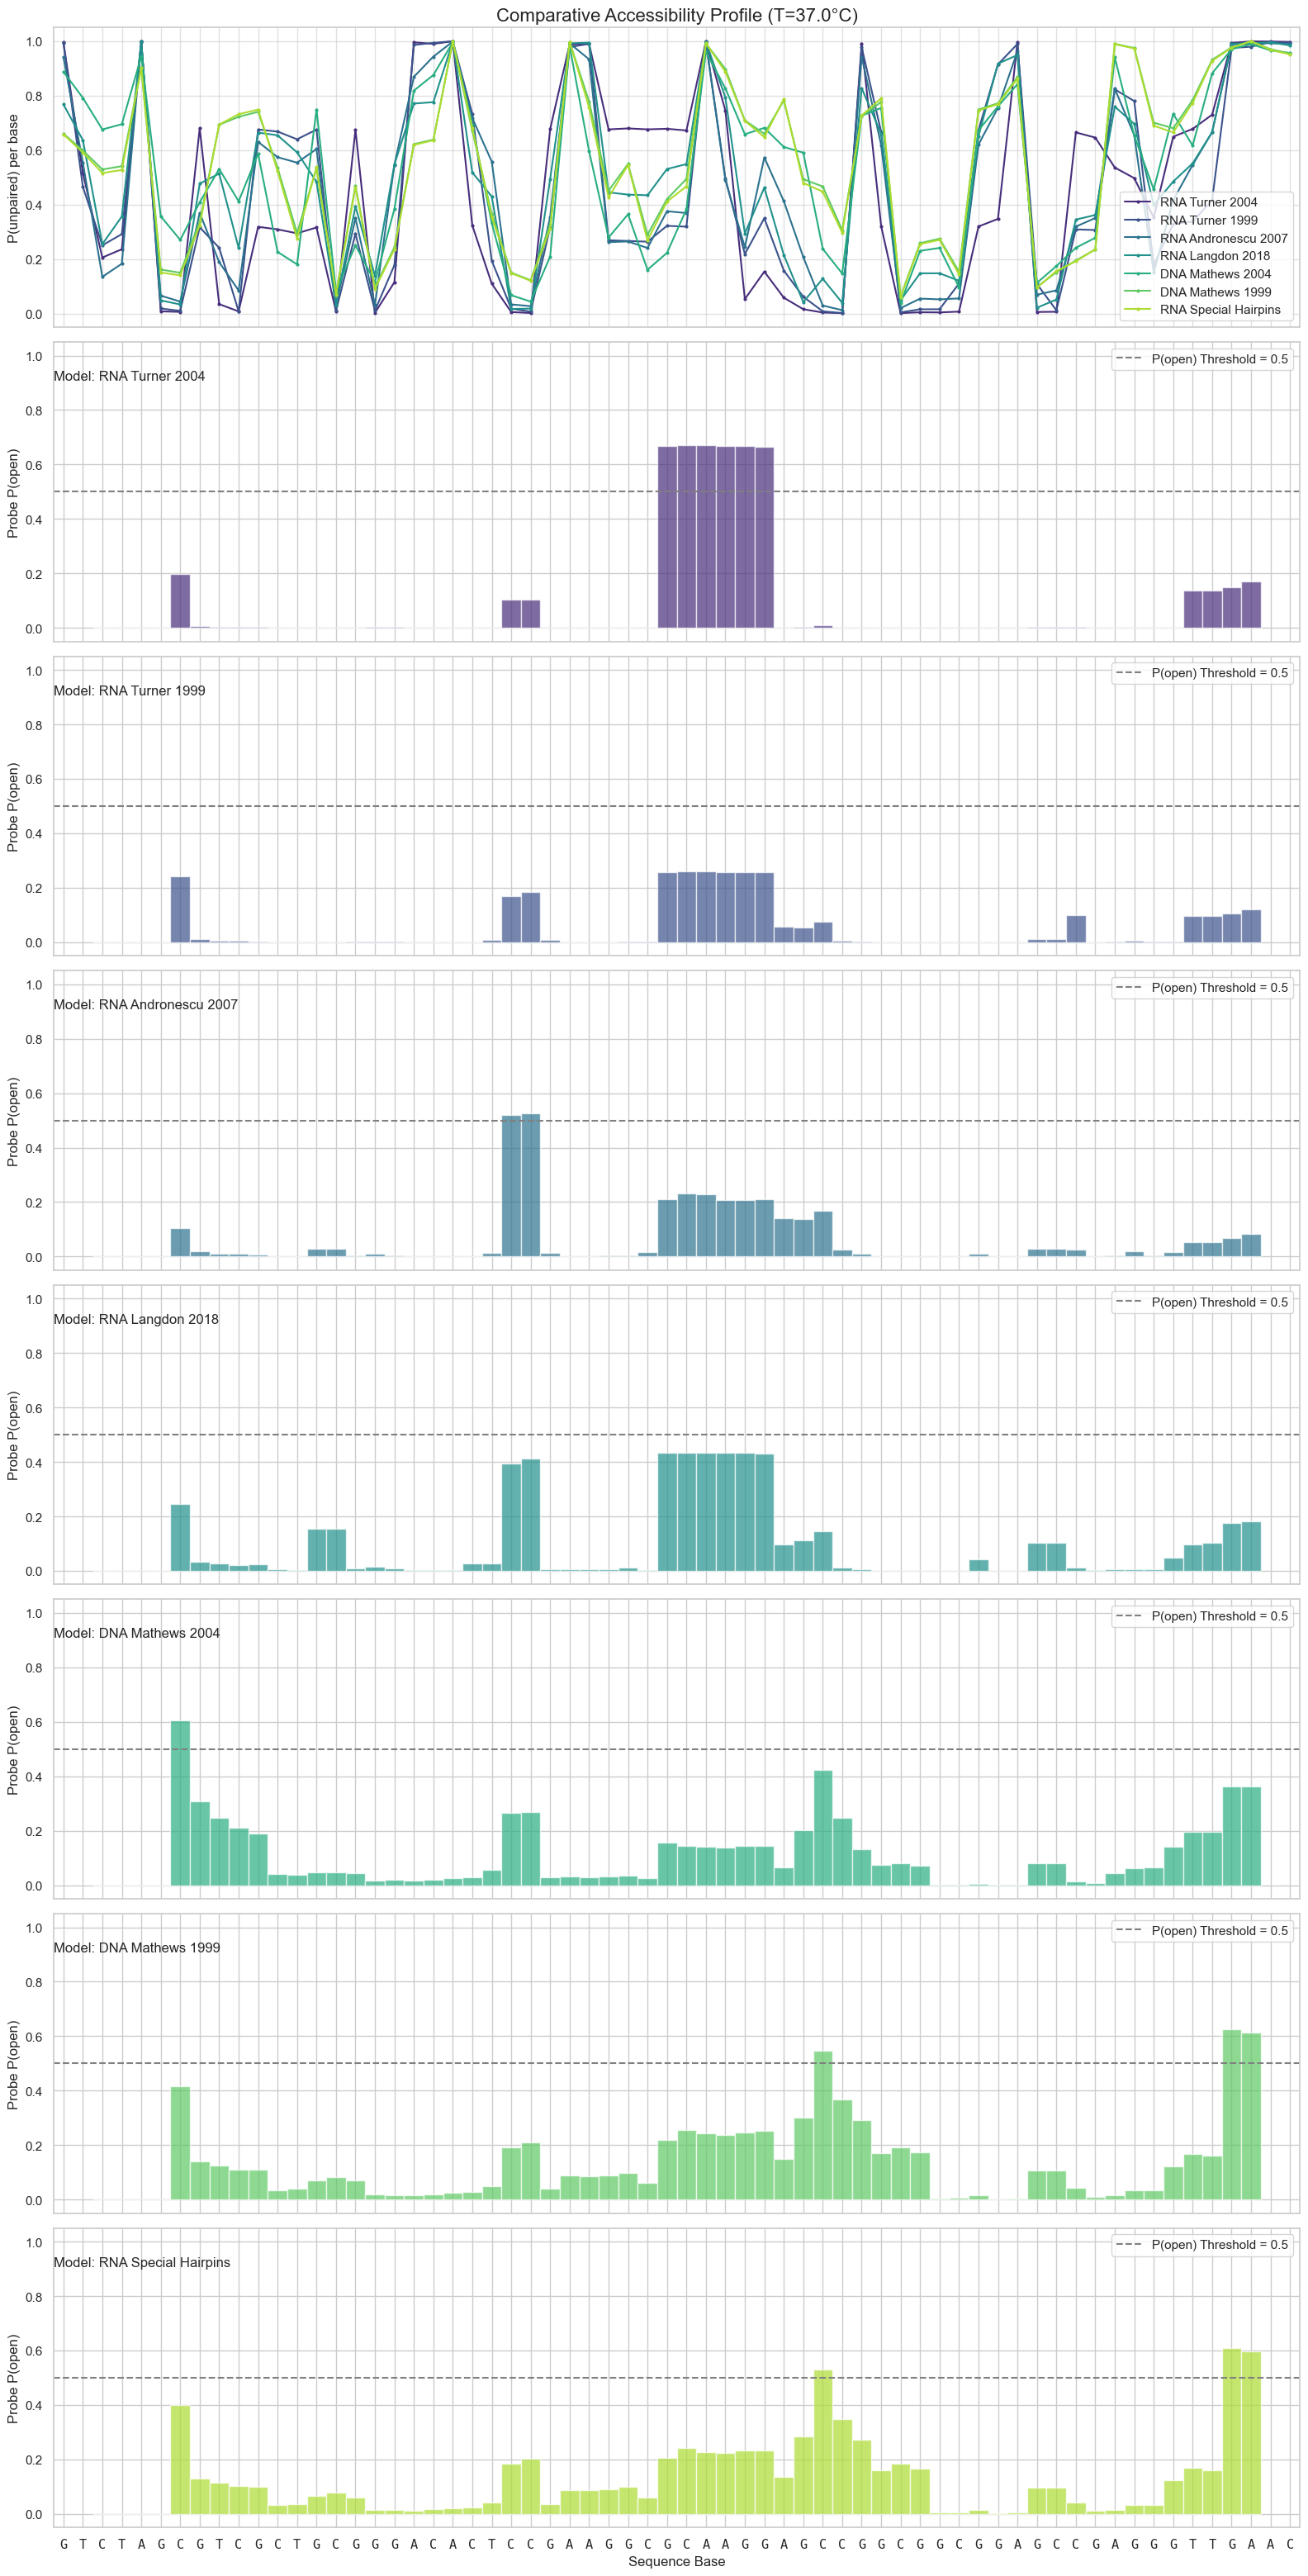



            ANALYSIS AT DENATURATION TEMPERATURE            
--- Running Full Comparative Analysis at 95.0°C ---
Input Sequence (L=64, GC=70.3%):
GTCTAGCGTCGCTGCGGGACACTCCGAAGGCGCAAGGAGCCGGCGGCGGAGCCGAGGGTTGAAC

-- Analyzing with model: RNA Turner 2004 --
  Fraction of Open 5bp Sites: 0.217

-- Analyzing with model: RNA Turner 1999 --
  Fraction of Open 5bp Sites: 0.817

-- Analyzing with model: RNA Andronescu 2007 --
  Fraction of Open 5bp Sites: 0.933

-- Analyzing with model: RNA Langdon 2018 --
  Fraction of Open 5bp Sites: 0.450

-- Analyzing with model: DNA Mathews 2004 --
  Fraction of Open 5bp Sites: 0.000

-- Analyzing with model: DNA Mathews 1999 --
  Fraction of Open 5bp Sites: 0.017

-- Analyzing with model: RNA Special Hairpins --
  Fraction of Open 5bp Sites: 0.017


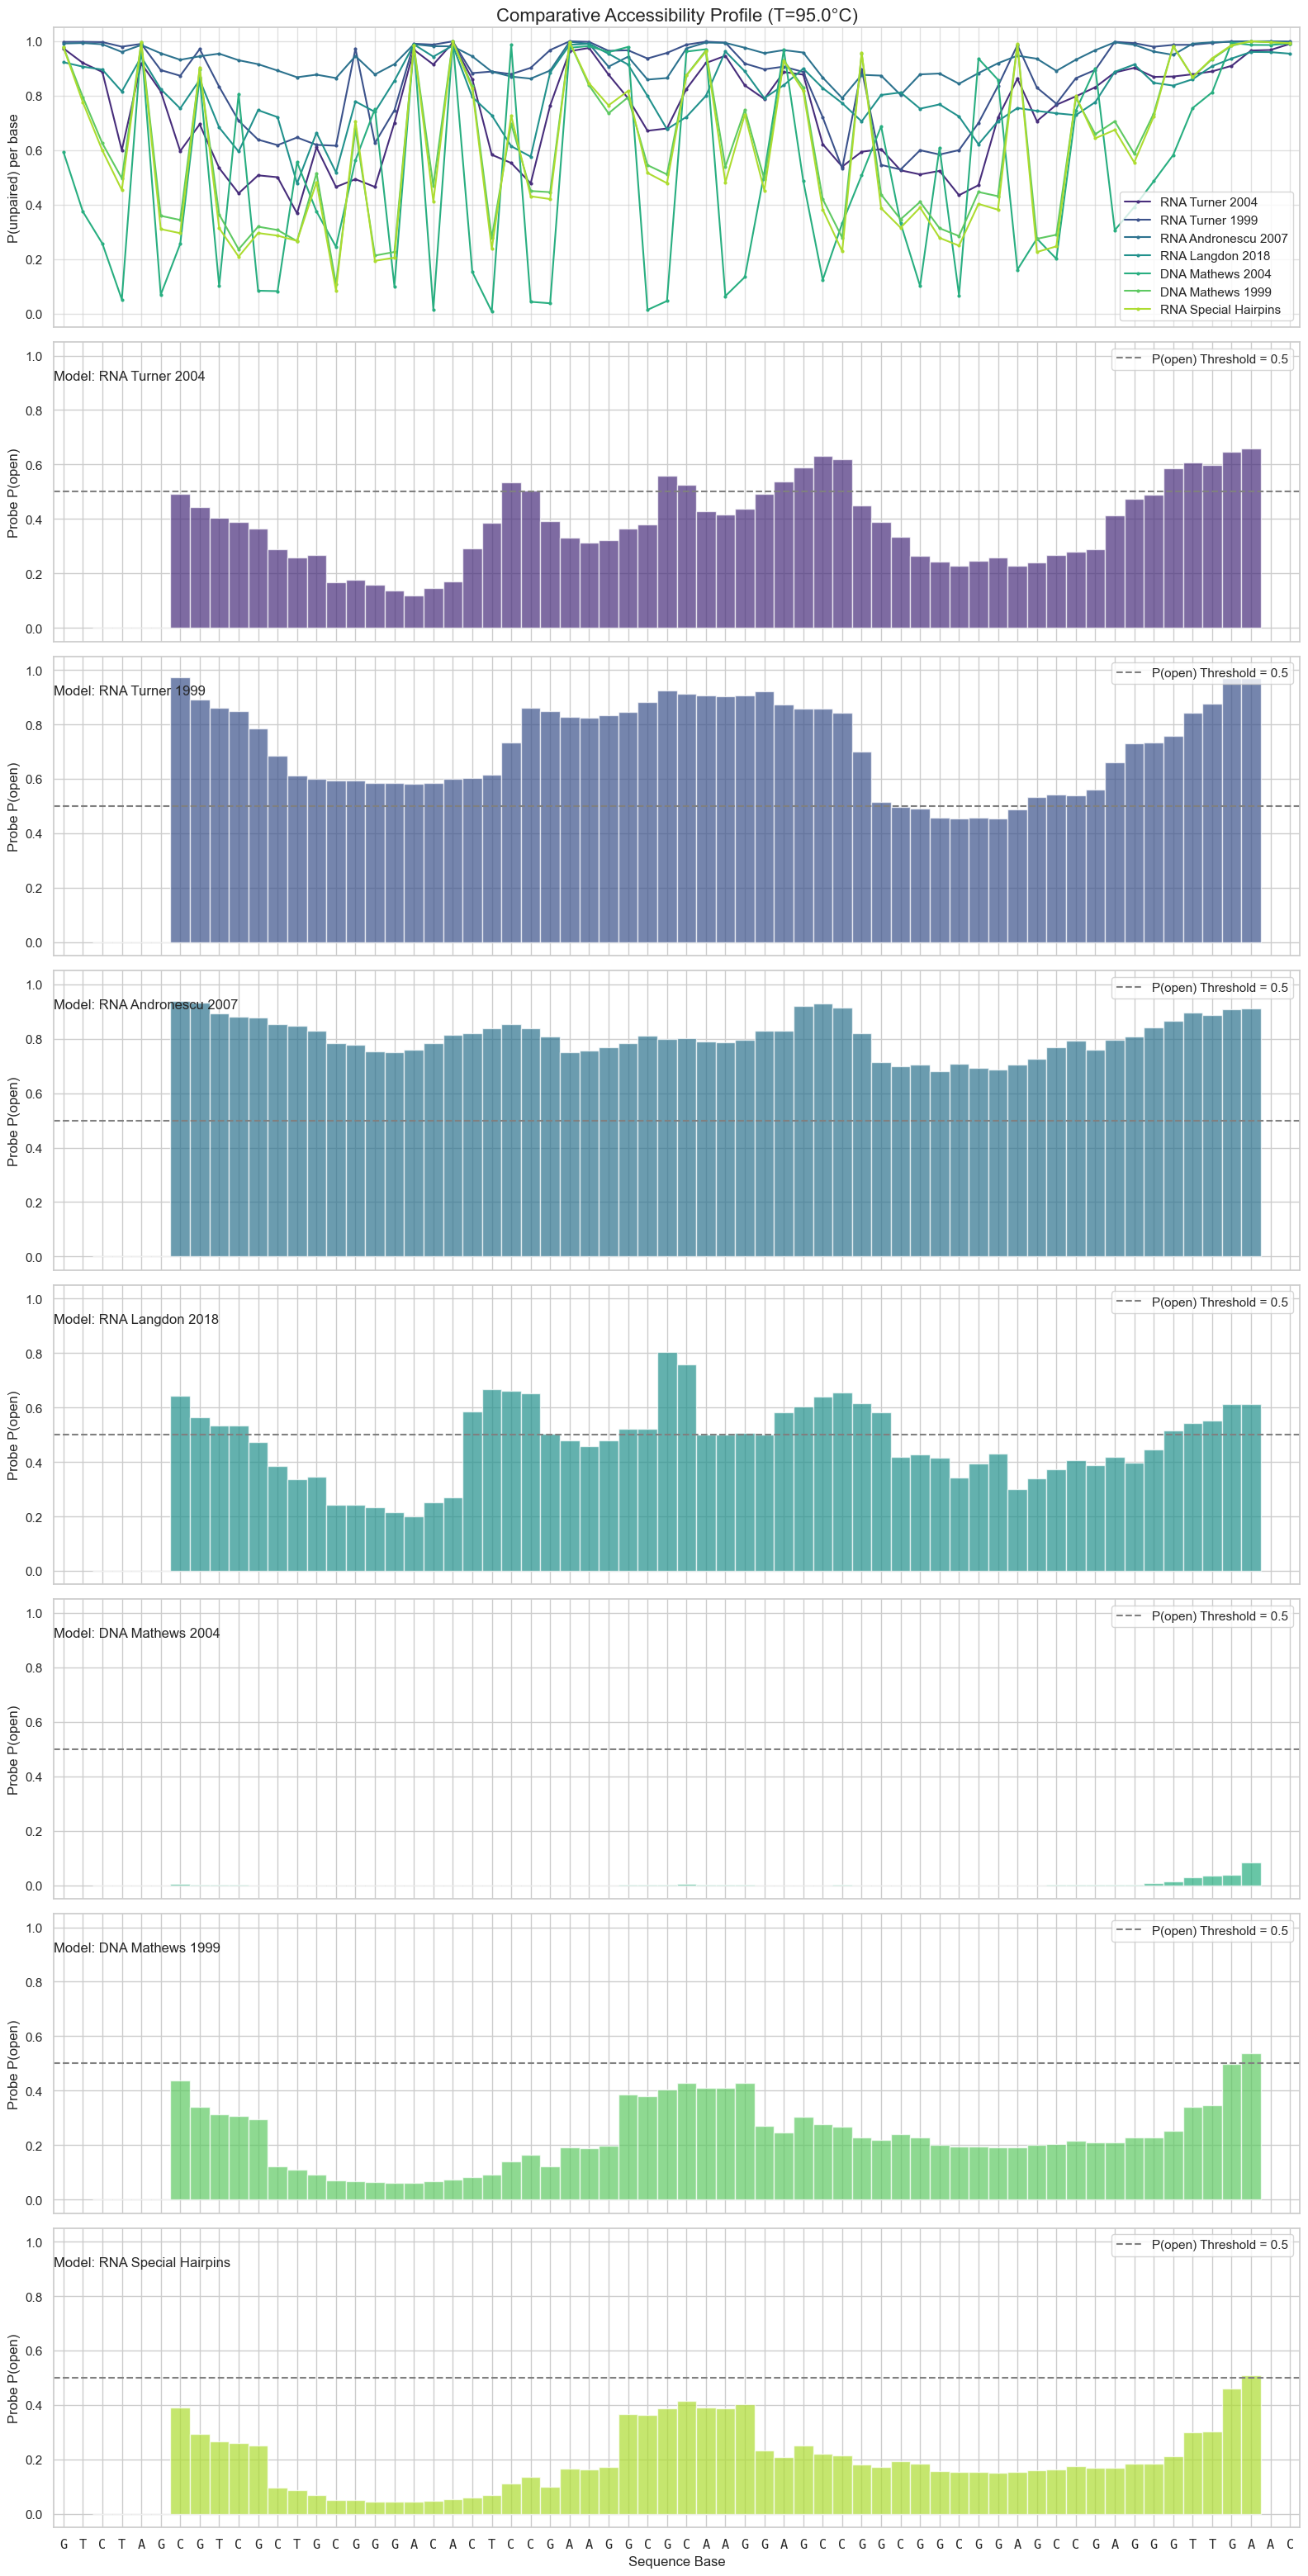

In [28]:
# Cell 12: Advanced Standalone Analyzer with Variable Temperature

def run_comparative_analysis(
    sequence_to_test: str, 
    effective_temp_c: float = 88.0, 
    force_base_labels: bool = False
):
    """
    Analyzes a single DNA sequence using all available ViennaRNA energy models at a 
    user-specified temperature and plots a comparative accessibility profile.
    
    Args:
        sequence_to_test (str): The DNA sequence to analyze.
        effective_temp_c (float): The temperature in Celsius to use for the simulation. 
                                  Defaults to 88.0°C.
        force_base_labels (bool): If True, forces all bases to be shown on the x-axis,
                                  even for long sequences.
    """
    # --- Step 1: Imports & Setup (scoped) ---
    import re
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import RNA

    # --- Step 2: Set ViennaRNA Environment for this specific run ---
    # This now uses the function argument, making the analysis self-contained.
    RNA.cvar.temperature = float(effective_temp_c)
    # Note: The global salt concentration set in Cell 2 is still used.

    # --- Step 3: Configuration & Helpers ---
    PROBE_LENGTH = 5
    P_OPEN_THRESHOLD = 0.50
    MODELS_TO_COMPARE = [
        {"name": "RNA Turner 2004", "loader": RNA.params_load_RNA_Turner2004, "type": "RNA"},
        {"name": "RNA Turner 1999", "loader": RNA.params_load_RNA_Turner1999, "type": "RNA"},
        {"name": "RNA Andronescu 2007", "loader": RNA.params_load_RNA_Andronescu2007, "type": "RNA"},
        {"name": "RNA Langdon 2018", "loader": RNA.params_load_RNA_Langdon2018, "type": "RNA"},
        {"name": "DNA Mathews 2004", "loader": RNA.params_load_DNA_Mathews2004, "type": "DNA"},
        {"name": "DNA Mathews 1999", "loader": RNA.params_load_DNA_Mathews1999, "type": "DNA"},
        {"name": "RNA Special Hairpins", "loader": RNA.params_load_RNA_misc_special_hairpins, "type": "RNA"}
    ]

    def _calculate_gc_content(sequence: str) -> float:
        s = sequence.upper()
        return 100.0 * (s.count('G') + s.count('C')) / len(s) if s else 0.0

    def _get_up_matrix_local(sequence: str, ulength: int) -> np.ndarray:
        N = len(sequence)
        M = np.zeros((N + 1, ulength + 1), dtype=float)
        winSize = span = max(N, 100)
        mat = RNA.pfl_fold_up(sequence, int(ulength), winSize, span)
        if mat is None: return M
        try: # 1-based indexing
            for i in range(1, N + 1):
                row, maxL = mat[i], min(ulength, len(mat[i]) - 1)
                for L in range(1, maxL + 1): M[i, L] = row[L]
        except Exception: # 0-based fallback
            for i in range(N):
                row, maxL = mat[i], min(ulength, len(mat[i]))
                for L in range(maxL): M[i + 1, L + 1] = row[L]
        return M

    def _analyze_from_up(sequence: str, up: np.ndarray) -> dict:
        N, valid = len(sequence), len(sequence) - PROBE_LENGTH + 1
        p_open_array = np.array([up[i, PROBE_LENGTH] for i in range(1, max(0, valid) + 1)])
        frac_open_sites = np.mean(p_open_array >= P_OPEN_THRESHOLD) if valid > 0 else 0.0
        return {
            "frac_open_sites": frac_open_sites,
            "pu1": np.array([up[i, 1] for i in range(1, N + 1)]),
            "p_open_array": p_open_array
        }

    # --- Step 4: Main Logic ---
    print(f"--- Running Full Comparative Analysis at {effective_temp_c:.1f}°C ---")
    original_seq = re.sub(r'[^ATGC]', '', sequence_to_test.upper(), flags=re.IGNORECASE)
    if len(original_seq) < PROBE_LENGTH:
        print("Error: Sequence is too short.")
        return

    print(f"Input Sequence (L={len(original_seq)}, GC={_calculate_gc_content(original_seq):.1f}%):")
    print(original_seq)
    
    results = []
    for model in MODELS_TO_COMPARE:
        print(f"\n-- Analyzing with model: {model['name']} --")
        model['loader']()
        seq_for_model = original_seq.replace('T', 'U') if model['type'] == 'RNA' else original_seq
        up_matrix = _get_up_matrix_local(seq_for_model, PROBE_LENGTH)
        metrics = _analyze_from_up(seq_for_model, up_matrix)
        metrics['model_name'] = model['name']
        results.append(metrics)
        print(f"  Fraction of Open {PROBE_LENGTH}bp Sites: {metrics['frac_open_sites']:.3f}")

    # --- Step 5: Plotting ---
    N = len(original_seq)
    n_models = len(results)
    fig, axes = plt.subplots(n_models + 1, 1, figsize=(16, 4 * (n_models + 1)), sharex=True)
    palette = sns.color_palette("viridis", n_models)
    
    ax_pu1 = axes[0]
    for i, res in enumerate(results):
        ax_pu1.plot(np.arange(N), res['pu1'], marker='.', markersize=4, linestyle='-', label=res['model_name'], color=palette[i])
    ax_pu1.set_ylabel('P(unpaired) per base')
    ax_pu1.set_ylim(-0.05, 1.05)
    ax_pu1.set_title(f"Comparative Accessibility Profile (T={effective_temp_c:.1f}°C)", fontsize=16)
    ax_pu1.legend()
    ax_pu1.grid(True, alpha=0.6)

    for i, res in enumerate(results):
        ax = axes[i + 1]
        valid = N - PROBE_LENGTH + 1
        probe_pos = np.arange(valid) + (PROBE_LENGTH - 1) / 2
        ax.bar(probe_pos, res['p_open_array'], width=1.0, alpha=0.7, color=palette[i])
        ax.axhline(y=P_OPEN_THRESHOLD, color='gray', linestyle='--', label=f'P(open) Threshold = {P_OPEN_THRESHOLD}')
        ax.set_ylabel('Probe P(open)')
        ax.set_ylim(-0.05, 1.05)
        ax.legend(loc='upper right')
        ax.set_title(f"Model: {res['model_name']}", loc='left', fontsize=12, y=0.85)

    ax_final = axes[-1]
    ticks = np.arange(N)
    labels = list(original_seq)
    ax_final.set_xlabel('Sequence Base', fontsize=12)
    use_labels = force_base_labels or N <= 60
    if use_labels:
        ax_final.set_xticks(ticks)
        ax_final.set_xticklabels(labels, fontfamily='monospace', rotation=0, ha='center')
    else:
        tick_spacing = max(1, N // 60)
        ax_final.set_xticks(ticks[::tick_spacing])
        ax_final.set_xticklabels([labels[i] for i in ticks[::tick_spacing]], fontfamily='monospace', rotation=0, ha='center')
    ax_final.set_xlim(-0.5, N - 0.5)
    
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


# --- INSTRUCTIONS ---
# Define the sequence to test once
sequence_to_test = """
>highly_structured_example
GCGTCGCTGCGGGACACTCCGAAGGCGCAAGGAGCCGGCGGCGGAGCCGAGGGTTGAAC
"""

# --- Example 1: Run at your main experimental temperature (88°C) ---
print("==========================================================")
print("          ANALYSIS AT EXPERIMENTAL TEMPERATURE            ")
print("==========================================================")
run_comparative_analysis(sequence_to_test, effective_temp_c=88.0)


# --- Example 2: Run at standard biological temperature (37°C) to see full structure ---
print("\n\n==========================================================")
print("             ANALYSIS AT BIOLOGICAL TEMPERATURE             ")
print("==========================================================")
run_comparative_analysis(sequence_to_test, effective_temp_c=37.0)


# --- Example 3: Run at a high denaturation temperature (95°C) to see everything "melt" ---
print("\n\n==========================================================")
print("            ANALYSIS AT DENATURATION TEMPERATURE            ")
print("==========================================================")
run_comparative_analysis(sequence_to_test, effective_temp_c=95.0)

--- Running End-Fraying Analysis at 88.0°C using DNA Mathews 2004 model ---

--- Accessibility by Region ---
  5' Terminal Region (first 10 sites): 0.002
  3' Terminal Region (last 10 sites):  0.033
  Central Core Region:                     0.000


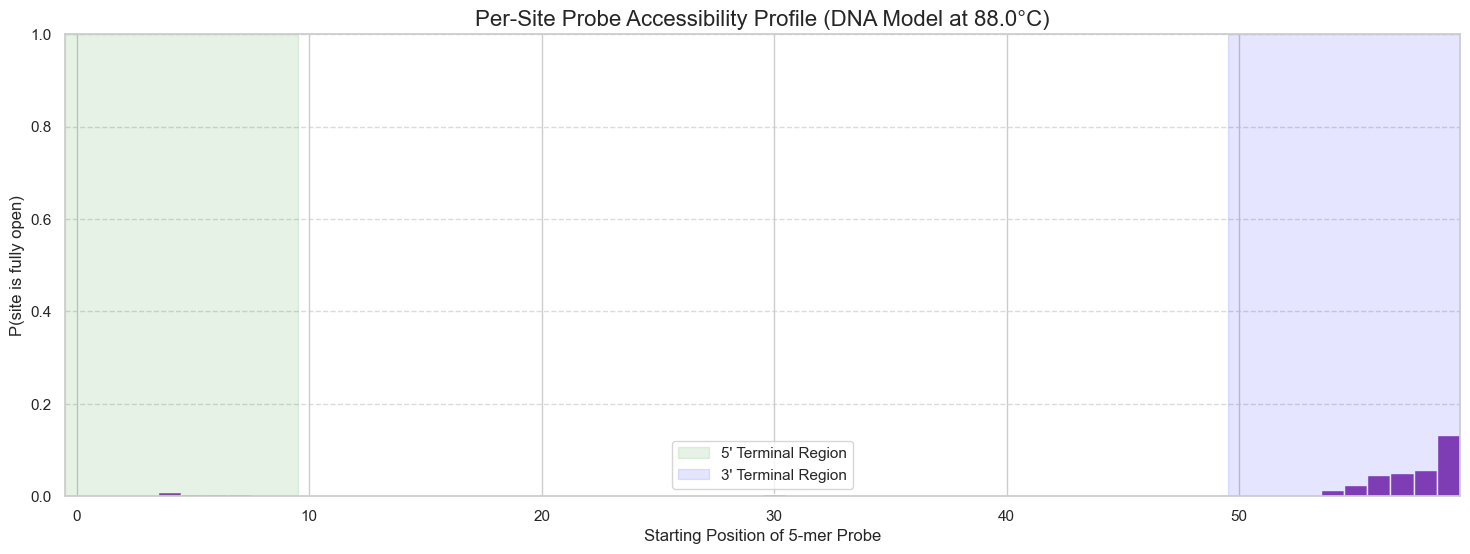

In [24]:
# Cell 14 (Corrected): Diagnostic Test for Model Discrepancies (End-Fraying)

def run_end_fraying_analysis(
    sequence_to_test: str,
    effective_temp_c: float = 88.0
):
    """
    Analyzes a single sequence to visualize the accessibility profile along its length,
    testing for the "end-fraying" effect.
    """
    # --- Step 1: Imports & Setup ---
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import RNA

    # --- Step 2: Configuration & Helpers ---
    PROBE_LENGTH = 5
    # Use the DNA model that showed extreme stability
    RNA.params_load_DNA_Mathews2004()
    RNA.cvar.temperature = effective_temp_c
    
    # CORRECTED helper function that takes a sequence string
    def _get_up_matrix_from_sequence(sequence: str, ulength: int) -> np.ndarray:
        N = len(sequence)
        # Call the global RNA.pfl_fold_up function, not a method of an object
        mat = RNA.pfl_fold_up(sequence, ulength, max(N, 100), max(N, 100))
        M = np.zeros((N + 1, ulength + 1))
        if mat is None: return M
        try: # 1-based indexing
            for i in range(1, N + 1):
                row, maxL = mat[i], min(ulength, len(mat[i]) - 1)
                for L in range(1, maxL + 1): M[i, L] = row[L]
        except Exception: # 0-based fallback
            for i in range(N):
                row, maxL = mat[i], min(ulength, len(mat[i]))
                for L in range(maxL): M[i + 1, L + 1] = row[L]
        return M

    # --- Step 3: Main Logic ---
    print(f"--- Running End-Fraying Analysis at {effective_temp_c:.1f}°C using DNA Mathews 2004 model ---")
    original_seq = re.sub(r'[^ATGC]', '', sequence_to_test.upper(), flags=re.IGNORECASE)
    N = len(original_seq)
    
    # Call the corrected helper function with the sequence string
    up_matrix = _get_up_matrix_from_sequence(original_seq, PROBE_LENGTH)
    
    valid_sites = N - PROBE_LENGTH + 1
    p_open_array = np.array([up_matrix[i, PROBE_LENGTH] for i in range(1, valid_sites + 1)])

    # --- Step 4: Quantitative Analysis ---
    end_region_size = 10
    if 2 * end_region_size > valid_sites:
        end_region_size = valid_sites // 2

    p_open_5prime = p_open_array[:end_region_size]
    p_open_3prime = p_open_array[-end_region_size:]
    p_open_core = p_open_array[end_region_size:-end_region_size]
    
    avg_acc_5prime = np.mean(p_open_5prime) if p_open_5prime.size > 0 else 0
    avg_acc_3prime = np.mean(p_open_3prime) if p_open_3prime.size > 0 else 0
    avg_acc_core = np.mean(p_open_core) if p_open_core.size > 0 else 0
    
    print("\n--- Accessibility by Region ---")
    print(f"  5' Terminal Region (first {end_region_size} sites): {avg_acc_5prime:.3f}")
    print(f"  3' Terminal Region (last {end_region_size} sites):  {avg_acc_3prime:.3f}")
    print(f"  Central Core Region:                     {avg_acc_core:.3f}")

    # --- Step 5: Plotting ---
    plt.figure(figsize=(18, 6))
    probe_positions = np.arange(valid_sites)
    plt.bar(probe_positions, p_open_array, width=1.0, color="#8e44ad")
    
    plt.axvspan(-0.5, end_region_size - 0.5, color='green', alpha=0.1, label="5' Terminal Region")
    plt.axvspan(valid_sites - end_region_size - 0.5, valid_sites - 0.5, color='blue', alpha=0.1, label="3' Terminal Region")
    
    plt.title(f"Per-Site Probe Accessibility Profile (DNA Model at {effective_temp_c}°C)", fontsize=16)
    plt.xlabel("Starting Position of 5-mer Probe")
    plt.ylabel("P(site is fully open)")
    plt.ylim(0, 1)
    plt.xlim(-0.5, valid_sites - 0.5)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# --- INSTRUCTIONS ---
# Use the GC-rich sequence that gave the inaccessible result
sequence_to_test = """
>highly_structured_example
GCGTCGCTGCGGGACACTCCGAAGGCGCAAGGAGCCGGCGGCGGAGCCGAGGGTTGAAC
"""

run_end_fraying_analysis(sequence_to_test, effective_temp_c=88.0)